In [167]:
# Script to compute TOU pricing for each time period in a dataset and return a modified dataset.
# Input: CSV file of daily consumption with time/date data as one column
# Output: CSV file of daily consumption with TOU pricing data added

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'


In [168]:
df_all = pd.read_csv('15minute_data_california.csv')
df_all = df_all[['dataid','local_15min', 'grid', 'solar']]

df_one = df_all.loc[df_all.dataid == 9836]

# Create column subtracting out PV output:
df_one["load"] = df_one["grid"] + df_one["solar"]

# Convert first column to datetime, removing seconds:
map1 = map(lambda s: s[:-3], df_one.local_15min.to_numpy())
df_one["datet"]= pd.to_datetime(list(map1))
df_one.drop("local_15min", inplace=True, axis=1)
df_one.drop("dataid", inplace=True, axis=1)
df_one.head()

# repeat 07-08 - 07-14 data for 07-01 - 07-07
df_week1 = df_one.loc[(df_one.datet >= '07-08-2014') & (df_one.datet < '07-15-2014')]
df_week1.reset_index(drop=True, inplace=True)
df_week1.datet = pd.date_range(start="07-01-2014", end="07-07-2014 23:45:00", freq="15T")
df2 = pd.concat([df_week1, df_one])
df2.reset_index(inplace=True, drop=True)

df2_1 = df2.loc[~((df2.datet >= '07-01-2014') & (df2.datet < '01-01-2015'))]
df2_2 = df2.loc[((df2.datet >= '07-01-2014') & (df2.datet < '01-01-2015'))]
df2_2.datet = df2_2.datet + pd.DateOffset(years=1)
df = pd.concat([df2_1, df2_2])
df = df.set_index("datet")
df = df.reindex(pd.date_range(start="01-01-2015", end="12-31-2015 23:45:00", freq="15T"))
df = df.interpolate()

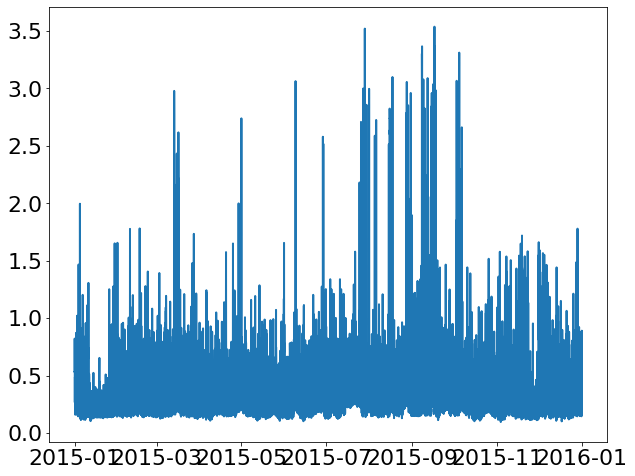

In [170]:
plt.plot(df.index, df.load)

In [171]:
# Tariff rate data for SDG&E TOU-DR-SES

SUMMER_MONTHS = [6, 7, 8, 9, 10]  # June 1 through Oct 31
WINTER_MONTHS = [1, 2, 3, 4, 5, 11, 12]  # Nov 1 through May 31th
ON_PEAK = [16, 17, 18, 19, 20]  # 4pm - 9pm, same for all days
SUMMER_OFF_PEAK = [
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    21,
    22,
    23,
]  # 6am - 4pm, 9pm - midnight
SUPER_OFF_PEAK = [
    0,
    1,
    2,
    3,
    4,
    5,
]  # midnight - 6am, same for all days except in March and April
WINTER_OFF_PEAK = [
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    21,
    22,
    23,
]  # 6am - 4pm, 9pm - midnight
WINTER_OFF_PEAK_MAR_APR = [
    6,
    7,
    8,
    9,
    14,
    15,
    21,
    22,
    23,
]  # 6am - 4pm, 9pm - midnight, excluding 10:00 a.m. – 2:00 p.m
WINTER_SUPER_OFF_PEAK_MAR_APR = [
    0,
    1,
    2,
    3,
    4,
    5,
    10,
    11,
    12,
    13,
]  # midnight - 6am; 10am = 2pm
OFF_PEAK_WEEKEND = [14, 15, 21, 22, 23]  # 2pm - 4pm; 9pm - midnight
SUPER_OFF_PEAK_WEEKEND = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
]  # midnight - 2pm


# NEW 2022: Rates from TOU DR-SES (since it is a system with backfeed solar)

# all in $/kWh
SUM_ON_PEAK_TOU = 0.63729
SUM_OFF_PEAK_TOU = 0.38904 
SUM_SUP_OFF_PEAK_TOU = 0.31245 

WIN_ON_PEAK_TOU = 0.41142
WIN_OFF_PEAK_TOU = 0.36418
WIN_SUP_OFF_PEAK_TOU = 0.30630


df = df.assign(tariff="")

# Summer TOU pricing, weekdays:
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(ON_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = SUM_ON_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(SUMMER_OFF_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = SUM_OFF_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(SUPER_OFF_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = SUM_SUP_OFF_PEAK_TOU

# Winter TOU pricing, weekdays:
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(ON_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = WIN_ON_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(WINTER_OFF_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = WIN_OFF_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(SUPER_OFF_PEAK)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = WIN_SUP_OFF_PEAK_TOU
# Adjust March and April TOU periods:
df.loc[
    df.index.month.isin([3, 4])
    & df.index.hour.isin(WINTER_SUPER_OFF_PEAK_MAR_APR)
    & df.index.weekday.isin([1, 2, 3, 4, 5]),
    "tariff",
] = WIN_SUP_OFF_PEAK_TOU

# Summer TOU pricing, weekends:
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(ON_PEAK)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = SUM_ON_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(OFF_PEAK_WEEKEND)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = SUM_OFF_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(SUPER_OFF_PEAK_WEEKEND)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = SUM_SUP_OFF_PEAK_TOU

# Winter TOU pricing, weekends:
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(ON_PEAK)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = WIN_ON_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(OFF_PEAK_WEEKEND)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = WIN_OFF_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(SUPER_OFF_PEAK_WEEKEND)
    & df.index.weekday.isin([0, 6]),
    "tariff",
] = WIN_SUP_OFF_PEAK_TOU


In [172]:
# Save to CSV
df.to_csv("load_tariff_9836.csv")

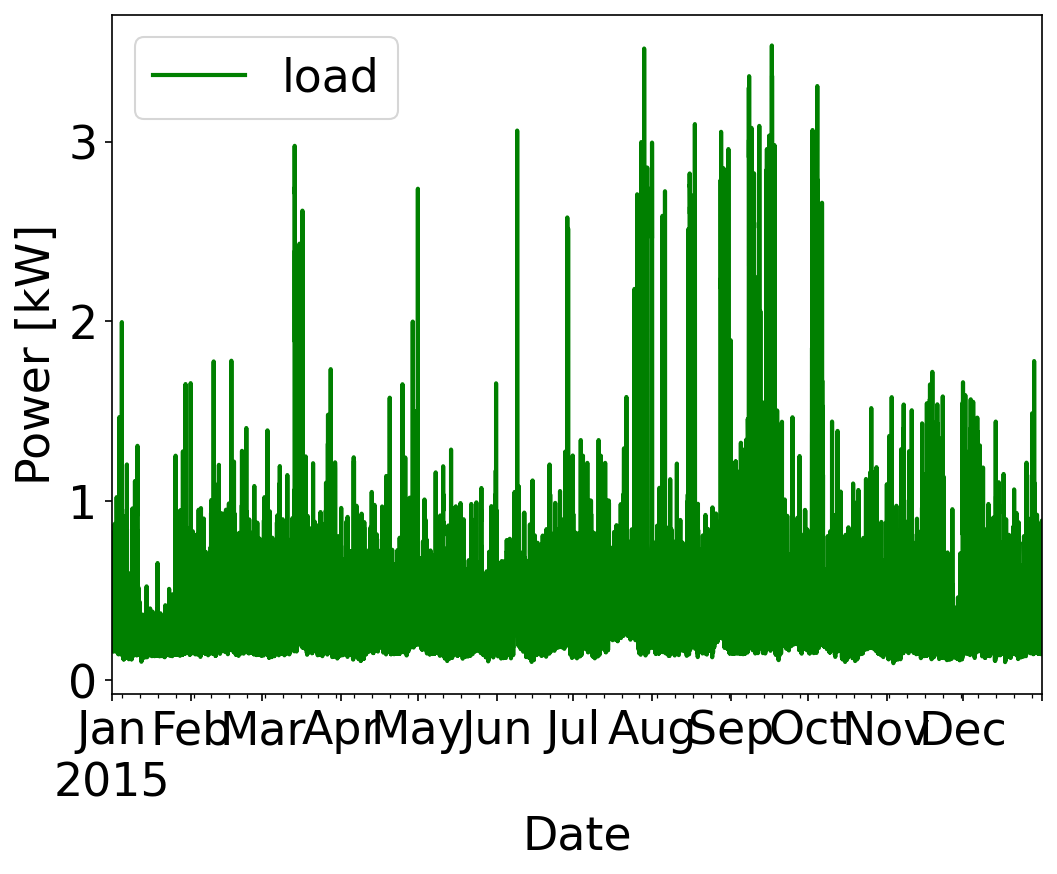

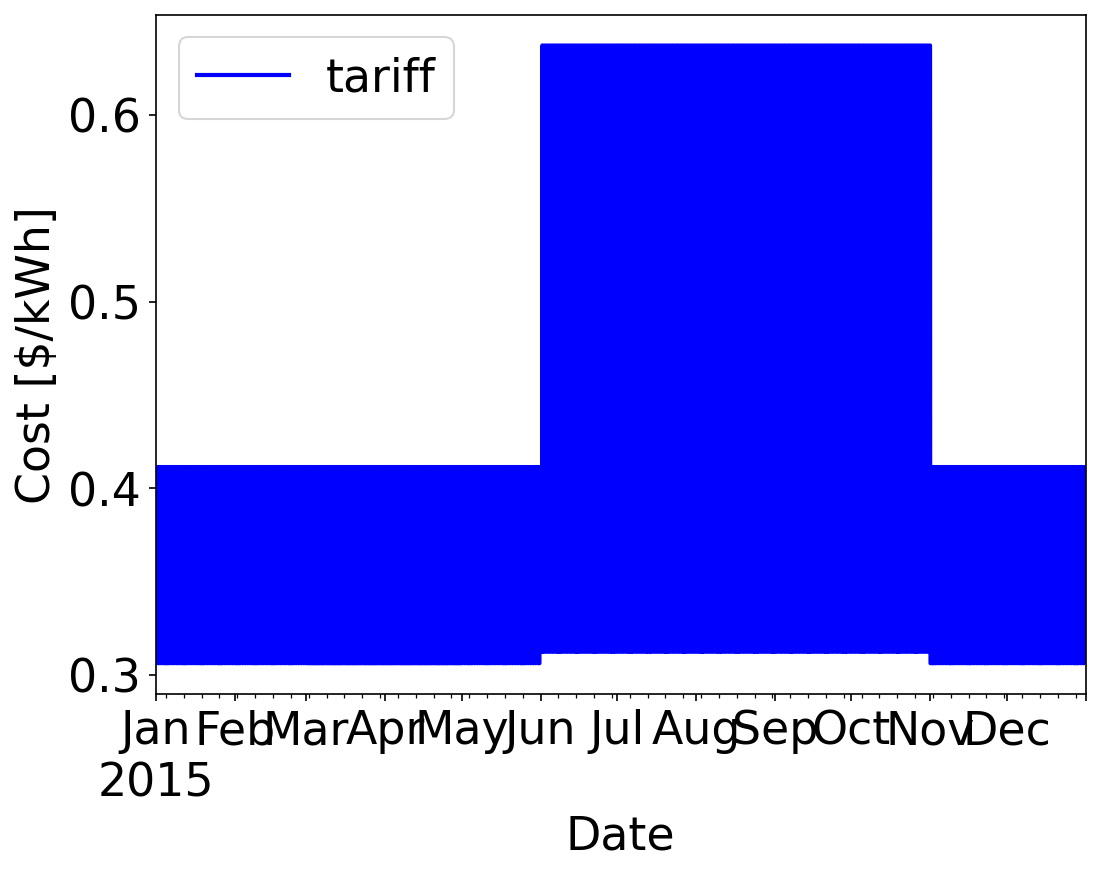

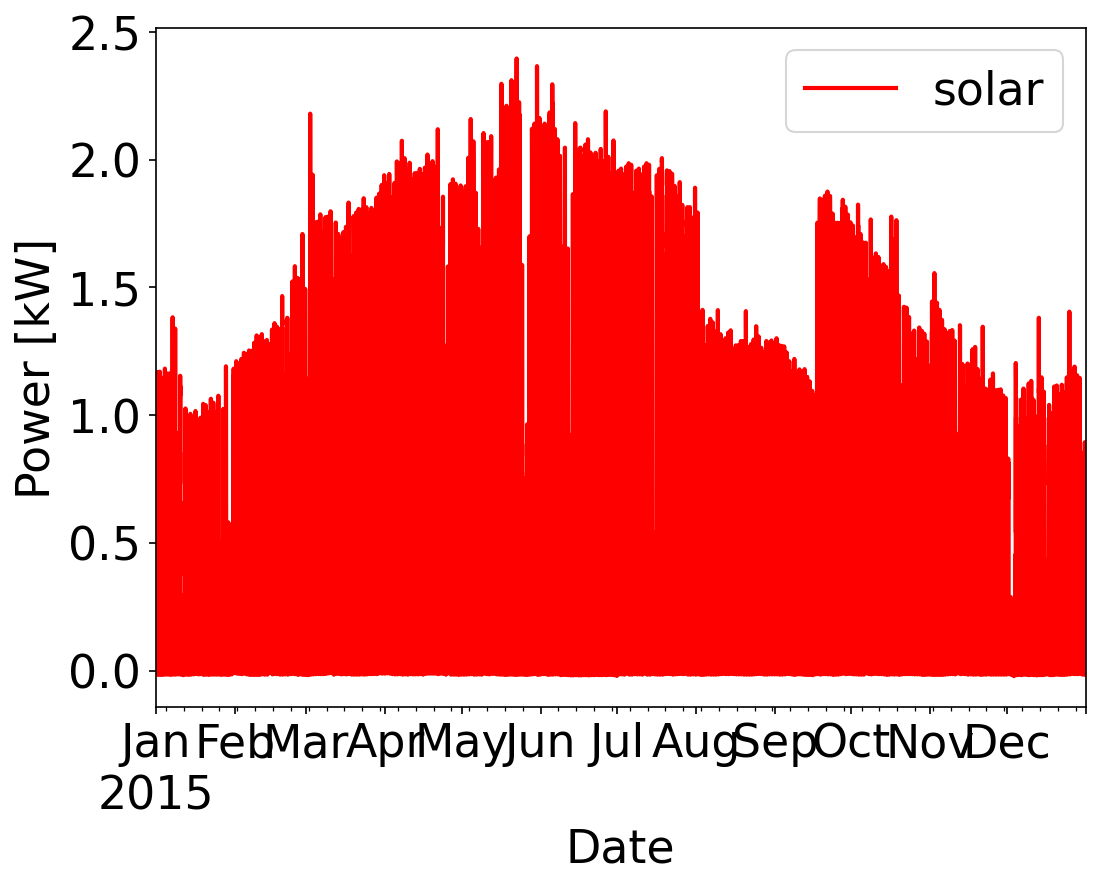

In [174]:
# Plot!
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.gca()
# df.plot(kind='line', x='dt', y='grid', ax=ax, xlabel='Date', ylabel='Power, kW')
# df.plot(kind='line', x='dt', y='solar', color='red', ax=ax, xlabel='Date', ylabel='Power, kW')
df.plot(
    kind="line",
    y="load",
    color="green",
    ax=ax,
    xlabel="Date",
    ylabel="Power [kW]",
)
fig.savefig("load_data.png")

# Plot tariff rate!
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.gca()
# df.plot(kind='line', x='dt', y='grid', ax=ax, xlabel='Date', ylabel='Power, kW')
# df.plot(kind='line', x='dt', y='solar', color='red', ax=ax, xlabel='Date', ylabel='Power, kW')
df.plot(
    kind="line",
    y="tariff",
    color="blue",
    ax=ax,
    xlabel="Date",
    ylabel="Cost [$/kWh]",
)
fig.savefig("tariff_data.png")


# Plot PV!
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.gca()
# df.plot(kind='line', x='dt', y='grid', ax=ax, xlabel='Date', ylabel='Power, kW')
# df.plot(kind='line', x='dt', y='solar', color='red', ax=ax, xlabel='Date', ylabel='Power, kW')
df.plot(
    kind="line",
    y="solar",
    color="red",
    ax=ax,
    xlabel="Date",
    ylabel="Power [kW]",
)
fig.savefig("solar_data.png")
